In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

Есть 2 базы данных: Аэропорты «Airport database» с информацией о всех аэропортах мира (название, страна, город, код IATA	, местоположение по широте и долготе) и Маршрутная сеть «Route database» с информацией о некоторых полетах.

## Задание 1

Найти 10 самых крупных аэропортов в Мире по сумме взлет/посадок. Результат в виде DataFrame, индекс 0 уровня Страна, индекс 1 уровня Название аэропорта + колонки: количество взлетов, посадок, суммы взлетов/посадок.

In [4]:
# выгружаем данные
airport_raw = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat',
                         names = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude',
                                  'Altitude', 'Timezone', 'DST', 'Tz database time zone', 'Type', 'Source'] )
airport_raw.head(2)

Airport ID            Name    City           Country IATA  ICAO  Latitude  \
0           1  Goroka Airport  Goroka  Papua New Guinea  GKA  AYGA  -6.08169   
1           2  Madang Airport  Madang  Papua New Guinea  MAG  AYMD  -5.20708   

    Longitude  Altitude Timezone DST Tz database time zone     Type  \
0  145.391998      5282       10   U  Pacific/Port_Moresby  airport   
1  145.789001        20       10   U  Pacific/Port_Moresby  airport   

        Source  
0  OurAirports  
1  OurAirports

In [5]:
# выгружаем данные
rout_raw = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat',
                      names = ['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 
                               'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])
rout_raw.head(2)

Airline Airline ID Source airport Source airport ID Destination airport  \
0      2B        410            AER              2965                 KZN   
1      2B        410            ASF              2966                 KZN   

  Destination airport ID Codeshare  Stops Equipment  
0                   2990       NaN      0       CR2  
1                   2990       NaN      0       CR2

In [6]:
# оставляем только необходимые для задания колонки
airports = airport_raw[['Name', 'Country', 'IATA']].copy()
# очень важно удалить аэропорты, где нет кода IATA, 
# так как именно по нему можно идентифицировать маршрут из 2й таблицы
airports = airports.replace('\\N', np.nan).dropna(subset='IATA')
airports['IATA'] = airports['IATA'].astype(str)
airports.tail()

Name      Country IATA
7684       Bilogai-Sugapa Airport    Indonesia  UGU
7687                Ramon Airport       Israel  ETM
7688               Rustaq Airport         Oman  MNH
7689         Laguindingan Airport  Philippines  CGY
7696  Desierto de Atacama Airport        Chile  CPO

In [7]:
# оставляем только необходимые для задания колонки
routs = rout_raw[['Source airport', 'Destination airport']]
routs = routs.reset_index()
routs

index Source airport Destination airport
0          0            AER                 KZN
1          1            ASF                 KZN
2          2            ASF                 MRV
3          3            CEK                 KZN
4          4            CEK                 OVB
...      ...            ...                 ...
67658  67658            WYA                 ADL
67659  67659            DME                 FRU
67660  67660            FRU                 DME
67661  67661            FRU                 OSS
67662  67662            OSS                 FRU

[67663 rows x 3 columns]

In [8]:
# считаем сколько раз каждый аэропорт был аэропортом отправления
sourse = routs.groupby('Source airport', as_index=False)['index'].count()
sourse.columns = ['IATA', 'takeoff']
display(sourse.head())

# считаем сколько раз каждый аэропорт был аэропортом назначения
destination = routs.groupby('Destination airport', as_index=False)['index'].count()
destination.columns = ['IATA', 'landing']
display(destination.head())

# заметим, что везде использовалось as_index=False, чтобы данные не фильтровались
# Не совсем верно использовать value_counts(), так как эта функция дополнительно сортирует таблицу
# это приводит к доп вычислениям компьютера

# соединяем 2 таблички по аэропортам и считаем сумму взлетов/посадок
dff = airports.merge(sourse, on='IATA', how='left').merge(destination, on='IATA', how='left')
dff['takeoff+landing'] = dff[['takeoff','landing']].sum(axis=1)
# выводим топ-10 аэропортов 
df10 = dff.nlargest(10, ['takeoff+landing']).set_index(['Country', 'Name']) #astype(int)
display(df10)

IATA  takeoff
0  AAE        9
1  AAL       20
2  AAN        2
3  AAQ        3
4  AAR        8

IATA  landing
0  AAE        9
1  AAL       21
2  AAN        2
3  AAQ        3
4  AAR        8

IATA  takeoff  \
Country        Name                                                             
United States  Hartsfield Jackson Atlanta International Airport  ATL    915.0   
               Chicago O'Hare International Airport              ORD    558.0   
China          Beijing Capital International Airport             PEK    535.0   
United Kingdom London Heathrow Airport                           LHR    527.0   
France         Charles de Gaulle International Airport           CDG    524.0   
Germany        Frankfurt am Main Airport                         FRA    497.0   
United States  Los Angeles International Airport                 LAX    492.0   
               Dallas Fort Worth International Airport           DFW    469.0   
               John F Kennedy International Airport              JFK    456.0   
Netherlands    Amsterdam Airport Schiphol                        AMS    453.0   

                                                                 landing  \
Country        Name                                                        
United States  Hartsfield Jackson Atlanta International Airport    911.0   
               Chicago O'Hare International Airport                550.0   
China          Beijing Capital International Airport               534.0   
United Kingdom London Heathrow Airport                             524.0   
France         Charles de Gaulle International Airport             517.0   
Germany        Frankfurt am Main Airport                           493.0   
United States  Los Angeles International Airport                   498.0   
               Dallas Fort Worth International Airport             467.0   
               John F Kennedy International Airport                455.0   
Netherlands    Amsterdam Airport Schiphol                          450.0   

                                                                 takeoff+landing  
Country        Name                                                               
United States  Hartsfield Jackson Atlanta International Airport           1826.0  
               Chicago O'Hare International Airport                       1108.0  
China          Beijing Capital International Airport                      1069.0  
United Kingdom London Heathrow Airport                                    1051.0  
France         Charles de Gaulle International Airport                    1041.0  
Germany        Frankfurt am Main Airport                                   990.0  
United States  Los Angeles International Airport                           990.0  
               Dallas Fort Worth International Airport                     936.0  
               John F Kennedy International Airport                        911.0  
Netherlands    Amsterdam Airport Schiphol                                  903.0

## Задание 2

Найти проблемные данные, ошибочные данные, не соответствия в данных, дубликаты и т.п.

#### Возможные ошибки в таблице взлетов-посадок:

-самолет взлетел, но никуда не приземлился (отсутствуют данные)

-самолет приземлился, но ниоткуда не взлетел (отсутствуют данные)

-маленькие буквы в коде IATA (надо привести к одному виду)


#### Возможные ошибки в таблице аэропортов, страны и кода

-ошибка в названии страны (ошибок нет, проверено в 3 задании с помощью awoc)

In [10]:
# проверяем есть ли дубликаты
rout_raw[rout_raw.duplicated()]

Empty DataFrame
Columns: [Airline, Airline ID, Source airport, Source airport ID, Destination airport, Destination airport ID, Codeshare, Stops, Equipment]
Index: []

In [11]:
# проверка отсутствия данных по некоторым направлениям полетов
routs.replace('\\N', np.nan, inplace=True)
routs[routs['Source airport'].isna()]

Empty DataFrame
Columns: [index, Source airport, Destination airport]
Index: []

In [12]:
# проверка отсутствия данных по некоторым направлениям полетов
routs[routs['Destination airport'].isna()]

Empty DataFrame
Columns: [index, Source airport, Destination airport]
Index: []

In [13]:
# смотрим есть ли код IATA, напечатанный маленькими буквами
mask1 = routs['Destination airport'].apply(str.isupper)
mask2 = routs['Source airport'].apply(str.isupper)
routs[(~(mask1&mask2))]

Empty DataFrame
Columns: [index, Source airport, Destination airport]
Index: []

## Задание 3

В таблицу 1 добавить колонку с названием континента (континенты: Европа, Азия, Африка, Сев. Америка, Юж. Америка, Австралия или Океания, Антарктида).

3.1 На карте мира, для каждого континента по отдельности, нанести все аэропорты континента-это 7 различных карт.

3.2 Для каждого континента взять 5 самых крупных аэропортов по сумме взлет/посадок. На карте Мира нанести эти аэропорты. На основе таблицы с  маршрутами установить взаимосвязи данных аэропортов между собой, если связь односторонняя отобразить ее в виде зеленой стрелки, если двухсторонняя красной линией.нии.

In [15]:
# pip install a-world-of-countries
# модуль перестал рабоать

In [16]:
# import awoc

In [17]:
# world = awoc.AWOC()

In [18]:
# # функция, которая присваивает континент по названию страны
# def get_cont(name):
#     try:
#         continent = world.get_country_continent_name(name)
#     except NameError: continent = dict_add.get(name) #np.nan
#     return continent

In [19]:
# словарь континентов для некотрых островов, которые не входят в справочник awoc/pycountry
dict_add = {
    "Cote d'Ivoire": 'Africa',
    'Congo (Brazzaville)': 'Africa',
    'Congo (Kinshasa)': 'Africa',
    'West Bank': 'Asia',
    'Midway Islands': 'Oceania',
    'French Guiana': 'South America',
    'Martinique': 'North America',
    'Guadeloupe': 'North America',
    'Virgin Islands': 'North America',
    'Burma': 'Asia',
    'Norfolk Island': 'Oceania',
    'Johnston Atoll': 'Oceania',
    'Cocos (Keeling) Islands': 'Oceania',
    'Svalbard': 'Europe',
    'Wake Island': 'Oceania',
    'Antarctica': 'Antarctica'
}

In [20]:
# pip install pycountry-convert

In [21]:
import pycountry_convert as pc_conv

In [22]:
import pycountry as pc

In [23]:
# функция, которая присваивает континент по названию страны

def get_cont(name):
    try:
        # Применяем нормализацию для поиска страны
        country = pc.countries.get(name=name) or pc.countries.lookup(name)
        country_code = country.alpha_2
        continent_code = pc_conv.country_alpha2_to_continent_code(country_code)
        continent = pc_conv.convert_continent_code_to_continent_name(continent_code)
    except LookupError:
        continent = dict_add.get(name)  # Используйте ваш словарь для поиска
    return continent

In [24]:
# определим континенты для каждого аэропорта
airport_raw['Continent'] =  [get_cont(i) for i in airport_raw['Country']]
airport_raw = airport_raw.replace('\\N', np.nan).dropna(subset='IATA')
airport_raw['IATA'] = airport_raw['IATA'].astype(str)
airport_raw.head(2)

Airport ID            Name    City           Country IATA  ICAO  Latitude  \
0           1  Goroka Airport  Goroka  Papua New Guinea  GKA  AYGA  -6.08169   
1           2  Madang Airport  Madang  Papua New Guinea  MAG  AYMD  -5.20708   

    Longitude  Altitude Timezone DST Tz database time zone     Type  \
0  145.391998      5282       10   U  Pacific/Port_Moresby  airport   
1  145.789001        20       10   U  Pacific/Port_Moresby  airport   

        Source Continent  
0  OurAirports   Oceania  
1  OurAirports   Oceania

In [25]:
# проверка, есть ли незаполненные континеты для некоторых стран
airport_raw[airport_raw['Continent'].isna()]['Country'].unique()

array(['Falkland Islands', 'Swaziland', 'Saint Helena', 'Reunion',
       'Cape Verde', 'Turkey', 'Macedonia', 'Micronesia',
       'Netherlands Antilles', 'Russia', 'Macau', 'Brunei', 'East Timor',
       'Palestine', 'Western Sahara'], dtype=object)

In [26]:
# разделим по континентам
africa = airport_raw[airport_raw['Continent']=='Africa']
antarctica = airport_raw[airport_raw['Continent']=='Antarctica']
asia = airport_raw[airport_raw['Continent']=='Asia']
europe = airport_raw[airport_raw['Continent']=='Europe']
north_amer= airport_raw[airport_raw['Continent']=='North America']
oceania= airport_raw[airport_raw['Continent']=='Oceania']
south_amer = airport_raw[airport_raw['Continent']=='South America']

In [27]:
import plotly.graph_objects as go

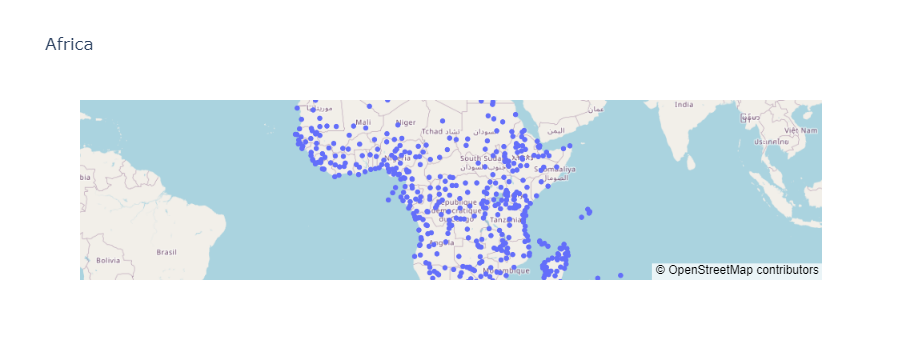

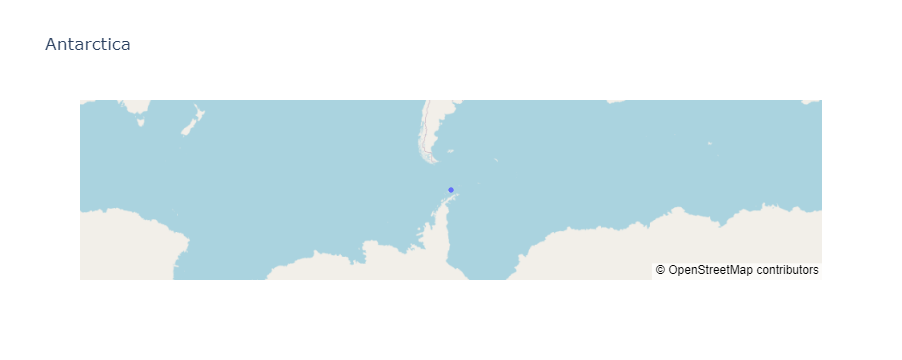

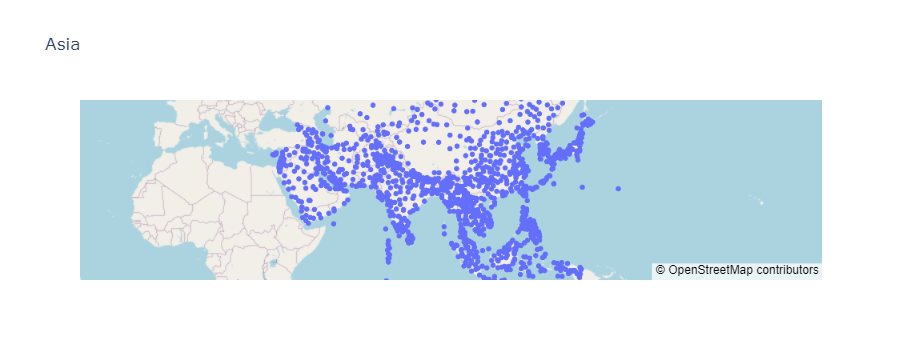

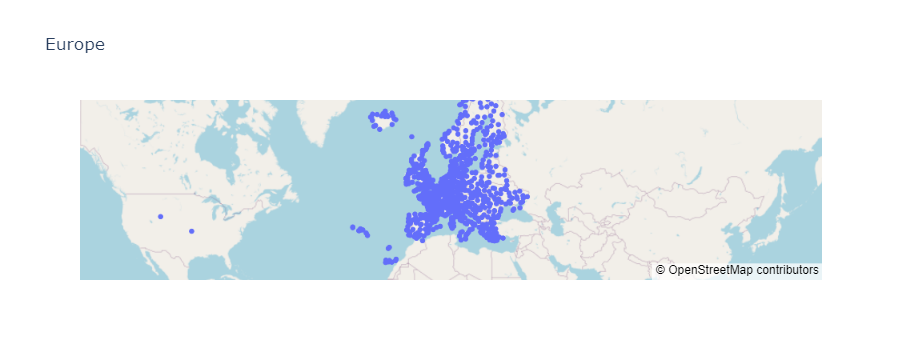

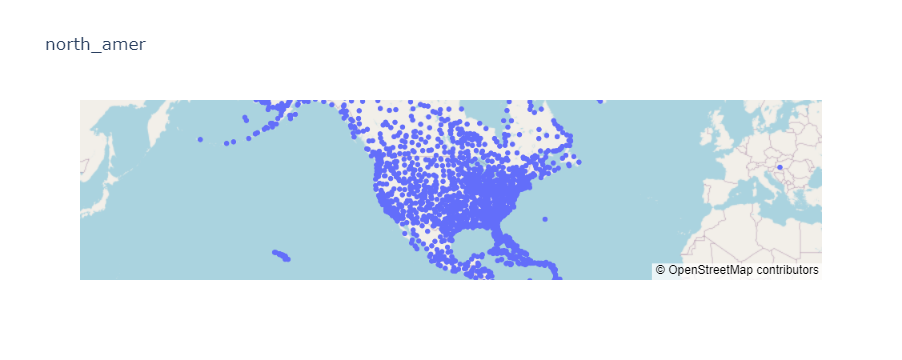

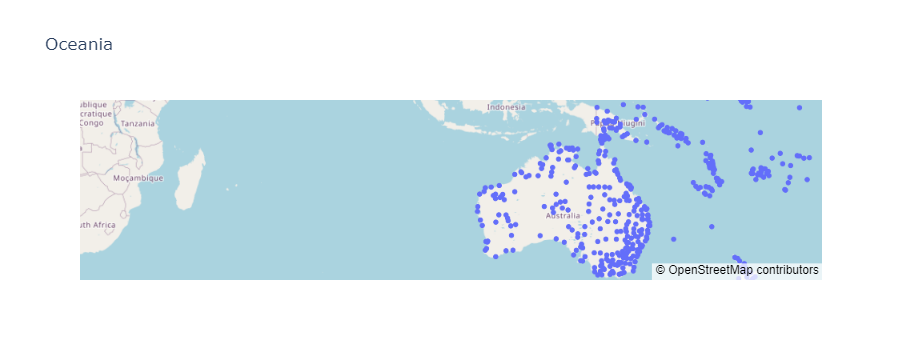

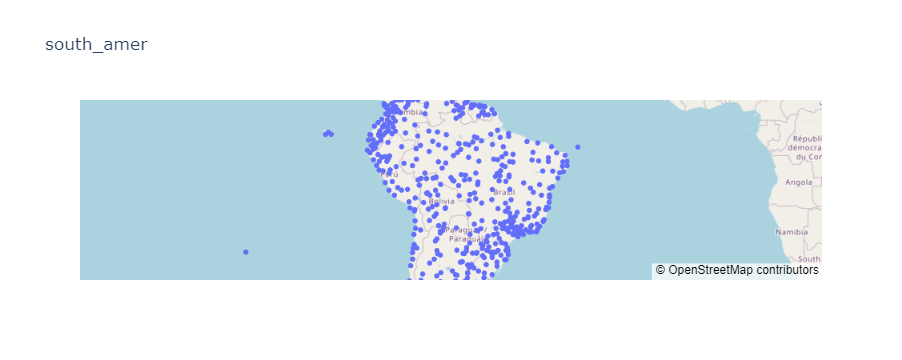

In [28]:
fig1 = go.Figure(go.Scattermapbox(lat=africa['Latitude'], lon=africa['Longitude'], text=africa['Name']))
map_center = go.layout.mapbox.Center(lat=(africa['Latitude'].mean()), 
                                     lon=(africa['Longitude'].mean()))
fig1.update_layout(mapbox_style="open-street-map", title='Africa',
                  mapbox=dict(center=map_center, zoom=1.5))
fig1.show()

fig2 = go.Figure(go.Scattermapbox(lat=antarctica['Latitude'], lon=antarctica['Longitude'], text=antarctica['Name']))
map_center = go.layout.mapbox.Center(lat=(antarctica['Latitude'].max()+antarctica['Latitude'].min())/2, 
                                     lon=(antarctica['Longitude'].max()+antarctica['Longitude'].min())/2)
fig2.update_layout(mapbox_style="open-street-map", title='Antarctica',
                  mapbox=dict(center=map_center, zoom=0.5))
fig2.show()

fig3 = go.Figure(go.Scattermapbox(lat=asia['Latitude'], lon=asia['Longitude'], text=asia['Name']))
map_center = go.layout.mapbox.Center(lat=(asia['Latitude'].mean()), 
                                     lon=(asia['Longitude'].mean()))
fig3.update_layout(mapbox_style="open-street-map", title='Asia',
                  mapbox=dict(center=map_center, zoom=1))
fig3.show()

fig4 = go.Figure(go.Scattermapbox(lat=europe['Latitude'], lon=europe['Longitude'], text=europe['Name']))
map_center = go.layout.mapbox.Center(lat=(europe['Latitude'].mean()), 
                                     lon=(europe['Longitude'].mean()))
fig4.update_layout(mapbox_style="open-street-map", title='Europe',
                  mapbox=dict(center=map_center, zoom=0.8))
fig4.show()

fig5 = go.Figure(go.Scattermapbox(lat=north_amer['Latitude'], lon=north_amer['Longitude'], text=north_amer['Name']))
map_center = go.layout.mapbox.Center(lat=(north_amer['Latitude'].mean()), 
                                     lon=(north_amer['Longitude'].mean()))
fig5.update_layout(mapbox_style="open-street-map", title='north_amer',
                  mapbox=dict(center=map_center, zoom=1))
fig5.show()

fig6 = go.Figure(go.Scattermapbox(lat=oceania['Latitude'], lon=oceania['Longitude'], text=oceania['Name']))
map_center = go.layout.mapbox.Center(lat=(oceania['Latitude'].mean()), 
                                     lon=(oceania['Longitude'].mean()))
fig6.update_layout(mapbox_style="open-street-map", title='Oceania',
                  mapbox=dict(center=map_center, zoom=1.6))
fig6.show()

fig7 = go.Figure(go.Scattermapbox(lat=south_amer['Latitude'], lon=south_amer['Longitude'], text=south_amer['Name']))
map_center = go.layout.mapbox.Center(lat=(south_amer['Latitude'].mean()), 
                                     lon=(south_amer['Longitude'].mean()))
fig7.update_layout(mapbox_style="open-street-map", title='south_amer',
                  mapbox=dict(center=map_center, zoom=1.6))
fig7.show()

Заметим, что в базе данных есть серьезные ошибки у некоторых аэропортов. По картам видно, что некоторые аэропорты находятся не в своих странах.

In [30]:
# Находим топ-5 аэропортов на каждом континенте и объединяем в одну таблицу
# используем dff, где уже в 1 задании были посчитаны для каждого аэропорта сумма взлетов и посадок
dff = dff[['IATA','takeoff', 'landing', 'takeoff+landing']]

africa5 = africa.merge(dff, on='IATA').sort_values('takeoff+landing', ascending=False).iloc[:5,:]
antarctica5 = antarctica.merge(dff, on='IATA').sort_values('takeoff+landing', ascending=False).iloc[:5,:]
asia5 = asia.merge(dff, on='IATA').sort_values('takeoff+landing', ascending=False).iloc[:5,:]
europe5 = europe.merge(dff, on='IATA').sort_values('takeoff+landing', ascending=False).iloc[:5,:]
north_amer5 = north_amer.merge(dff, on='IATA').sort_values('takeoff+landing', ascending=False).iloc[:5,:]
oceania5 = oceania.merge(dff, on='IATA').sort_values('takeoff+landing', ascending=False).iloc[:5,:]
south_amer5 = south_amer.merge(dff, on='IATA').sort_values('takeoff+landing', ascending=False).iloc[:5,:]

top_air = pd.concat([africa5, antarctica5, asia5, europe5, north_amer5, oceania5, south_amer5], ignore_index=True,sort=False)
top_air.set_index(['Continent', 'Name'])

Airport ID  \
Continent     Name                                                             
Africa        OR Tambo International Airport                             813   
              Cairo International Airport                               1128   
              Jomo Kenyatta International Airport                       4059   
              Mohammed V International Airport                          1074   
              Addis Ababa Bole International Airport                    1107   
Antarctica    Teniente Rodolfo Marsh Martin Base                        2661   
Asia          Beijing Capital International Airport                     3364   
              Shanghai Pudong International Airport                     3406   
              Singapore Changi Airport                                  3316   
              Incheon International Airport                             3930   
              Hong Kong International Airport                           3077   
Europe        London Heathrow Airport                                    507   
              Charles de Gaulle International Airport                   1382   
              Frankfurt am Main Airport                                  340   
              Amsterdam Airport Schiphol                                 580   
              Barcelona International Airport                           1218   
North America Hartsfield Jackson Atlanta International Airport          3682   
              Chicago O'Hare International Airport                      3830   
              Los Angeles International Airport                         3484   
              Dallas Fort Worth International Airport                   3670   
              John F Kennedy International Airport                      3797   
Oceania       Sydney Kingsford Smith International Airport              3361   
              Brisbane International Airport                            3320   
              Melbourne International Airport                           3339   
              Auckland International Airport                            2006   
              Perth International Airport                               3351   
South America Guarulhos - Governador André Franco Montoro Int...        2564   
              El Dorado International Airport                           2709   
              Jorge Chávez International Airport                        2789   
              Presidente Juscelino Kubistschek International ...        2531   
              Rio Galeão – Tom Jobim International Airport              2560   

                                                                               City  \
Continent     Name                                                                    
Africa        OR Tambo International Airport                           Johannesburg   
              Cairo International Airport                                     Cairo   
              Jomo Kenyatta International Airport                           Nairobi   
              Mohammed V International Airport                           Casablanca   
              Addis Ababa Bole International Airport                    Addis Ababa   
Antarctica    Teniente Rodolfo Marsh Martin Base                     Isla Rey Jorge   
Asia          Beijing Capital International Airport                         Beijing   
              Shanghai Pudong International Airport                        Shanghai   
              Singapore Changi Airport                                    Singapore   
              Incheon International Airport                                   Seoul   
              Hong Kong International Airport                             Hong Kong   
Europe        London Heathrow Airport                                        London   
              Charles de Gaulle International Airport                         Paris   
              Frankfurt am Main Airport                                   Frankfurt   
              Amsterdam Airport S

In [33]:
# Находим маршруты, связанные с крупнейшими аэропортами
def top_routs(iata):
    if iata in np.array(top_air['IATA']):
        return True
    else:
        return False

mask1 = routs['Destination airport'].apply(top_routs)
mask2 = routs['Source airport'].apply(top_routs)
new_routs = routs[mask1&mask2].drop(columns=['index']).drop_duplicates()
new_routs

Source airport Destination airport
385              HKG                 SIN
393              PER                 SIN
402              SIN                 HKG
407              SIN                 PER
512              BCN                 CMN
...              ...                 ...
50420            BCN                 SIN
50467            GRU                 BCN
50527            SIN                 BCN
56521            GRU                 ORD
57306            ORD                 GRU

[400 rows x 2 columns]

In [34]:
merged_source = new_routs.merge(top_air, left_on='Source airport', right_on='IATA')
merged_routes = merged_source.merge(top_air, left_on='Destination airport', right_on='IATA', suffixes=('_dep', '_dest'))

# Определяем двусторонние маршруты туда-обратно за 1
merged_routes['Roundtrip'] = merged_routes.apply(lambda row: 1 if ((row['Destination airport'], row['Source airport']) in merged_routes[['Source airport', 'Destination airport']].itertuples(index=False)) else 0, axis=1)

In [35]:
# pip install folium

In [36]:
import folium

In [37]:
# Создаем карту
m = folium.Map(location=[37.7749, -95.4194], zoom_start=4)
# Добавляем геолинии на карту
for _, row in merged_routes.iterrows():
    line_color = 'green' if row['Roundtrip'] == 0 else 'red'
    folium.PolyLine(
        locations=[(row['Latitude_dep'], row['Longitude_dep']),
                   (row['Latitude_dest'], row['Longitude_dest'])],
        color=line_color,
        weight=2,
        opacity=0.7
    ).add_to(m)

    folium.Marker(
            location=(row['Latitude_dep'], row['Longitude_dep']),
            popup=row['IATA_dep'],  # Название аэропорта
            icon=folium.Icon(color='blue')
    ).add_to(m)
    
    folium.Marker(
        location=(row['Latitude_dest'], row['Longitude_dest']),
        popup=row['IATA_dest'],  # Название аэропорта
        icon=folium.Icon(color='blue')
    ).add_to(m)

# отобразить карту
m